In [1]:
import numpy as np
import torch
from torchvision import transforms, models, datasets
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [2]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [3]:
class TryRandomSolarize(object):
    def __init__(self, threshold, p) -> None:
        self.solarize = transforms.RandomSolarize(threshold,p)
    def __call__(self,sample):
        try:
            
            img = self.solarize(img)
        except:
            img = sample
        return sample

In [4]:

train_path = "./../images/patches/ic_modelset/train/"
val_path = "./../images/patches/ic_modelset/val/"
transformation = transforms.Compose([TryRandomSolarize(100.0,0.5),
                                     transforms.RandomPerspective(0.6, p=0.5),
                                     transforms.GaussianBlur(5),
                                     transforms.Resize((224,224)),
                                     transforms.ToTensor()
                                    ])
train_set = datasets.ImageFolder(root = train_path, transform=transformation)
test_set = datasets.ImageFolder(root = val_path, transform=transforms.Compose([transforms.Resize((224,224)),
                                                                                transforms.ToTensor()]))





In [5]:


# csvloader = torch.utils.data.DataLoader(train_set, batch_size = 1, shuffle = True)
# imgs, lbls= [], []
# for img, lbl in csvloader:
#         lbls.append(lbl)
#         imgs.append(img)
    
# imgs = torch.cat(imgs, dim = 0)
# lbls = torch.cat(lbls,dim=0)
# torch.save(imgs, 'train_patchs_img.pt')
# torch.save(lbls, 'train_patches_lbl.pt')




In [6]:
#Create additional layers for snow classification
model = models.resnet50(weights =models.ResNet50_Weights.IMAGENET1K_V2)
for param in model.parameters():
    param.requires_grad = False   

model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,3),
    torch.nn.Softmax(dim= 1)
)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
#parameters

lr = 0.0001
batch_size = 256
epochs =10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr)
train_loader = torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle= True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= 1, shuffle= False)

In [16]:
def calc_test_accuracy(model, dataloader,epoch, save_pic = False, criterion =torch.nn.CrossEntropyLoss()):
      model.eval()
      val_loss = 0
      matrix = np.zeros((3,3))
      with torch.no_grad():
            for num, (i, l) in enumerate(dataloader):
                  if(save_pic):     
                        plt.imsave(f"image{num}.png",i.squeeze(0).permute(1,2,0).numpy() )
                 
                  if(l == torch.tensor([0])):
                        l = torch.tensor([1, 0,0])
                  elif(l == torch.tensor([1])):
                        l = torch.tensor([0, 1,0])
                  else:
                        l = torch.tensor([0, 0,1])
                  l = l.reshape([1,3])
                  i,l = i.to(device), l.to(device).float()
                  t_out = model(i)
                  
                  
                  val_loss+= criterion(t_out, l).item()
                  predicted = np.argmax(t_out.cpu().numpy(), axis = 1)
                  true_label = np.argmax(l.cpu().numpy(), axis =1)
                  
                  matrix[predicted, true_label]+=1
                        

                  
            
            stats = dict(
                  epoch = epoch,
                  vals = matrix,
                  loss = val_loss/np.sum(matrix)
            
            )
            # print(f'True positives: {TP}')
            # print(f'True negatives: {TN}')
            # print(f'False positives: {FP}')
            
            # print(f'False negatives: {FN}')
            return stats


In [9]:
# #training 
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# running_loss = 0 
# train_loss, test_loss = [],[]
# # model = torch.load("model.pth")
# model.train()
# verbose = 10
# steps = 0

# for epoch in range(0, epochs):
#     print(epoch)
#     steps = 0
#     for images,labels in train_loader:
       
#         steps += 1
#         if(steps %200 ==0):
#             print(f'steps: {steps}')
#         labels = torch.nn.functional.one_hot(labels)
#         images,labels = images.to(device), labels.to(device).to(torch.float)
        
#         optimizer.zero_grad()
#         out = model(images).to(torch.float)
#         loss = criterion(out, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
        
        
#     val_loss = 0
#     num_correct = 0
#     model.eval()
#     train_loss.append(running_loss/len(train_loader))
   
#     with torch.no_grad():
#         stats = calc_test_accuracy(model, test_loader, epoch+1)
        
#         test_loss.append(stats["loss"])
#         stats["training_loss"] = train_loss
#         torch.save(stats, f"stats-{epoch+1}.pt")
#         print(stats)
#     running_loss= 0
#     model.train()
#     torch.save(model, 'model.pth')
    
  


        

        
    

In [10]:
# model = torch.load('model.pth')
# stats = calc_test_accuracy(model, test_loader, epoch+1)
# stats["training_loss"] = train_loss
# torch.save(stats, f"stats-{epoch+1}.pt")
# print(stats)



In [17]:
model = torch.load('model.pth')
stats = calc_test_accuracy(model, test_loader, 0)
print(stats)



{'epoch': 0, 'vals': array([[1193.,  129.,   29.],
       [ 104., 1124.,   50.],
       [  33.,   77., 1251.]]), 'loss': 0.6705284702598601}


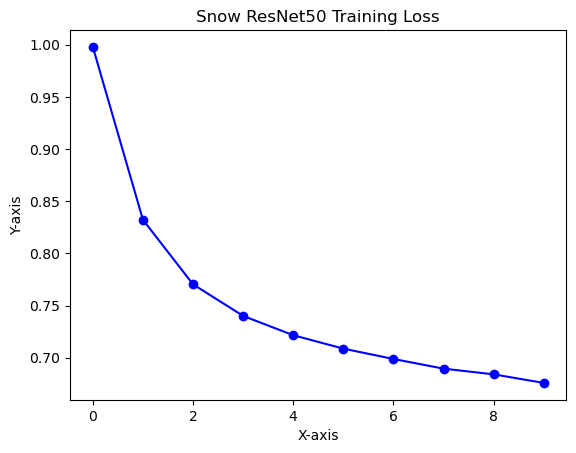

In [ ]:
fig, ax = plt.subplots()

# Plot the data
ax.plot(train_loss, marker='o', linestyle='-', color='b')

# Customize the plot
ax.set_title('Snow ResNet50 Training Loss')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Display the plot
plt.show()

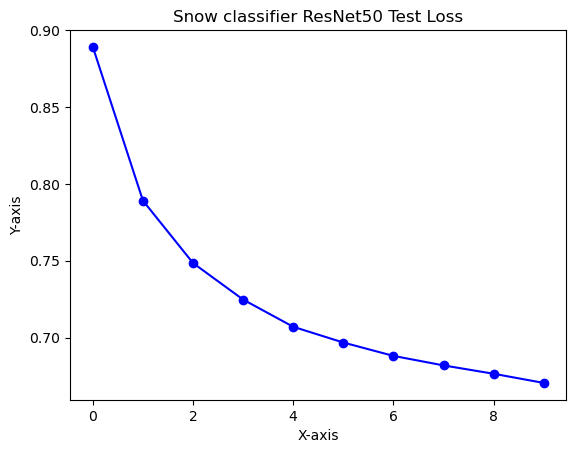

In [ ]:
fig, ax = plt.subplots()

# Plot the data
ax.plot(test_loss,marker='o', linestyle='-', color='b')

# Customize the plot
ax.set_title('Snow classifier ResNet50 Test Loss')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Display the plot
plt.show()

KeyError: 'accuracy'

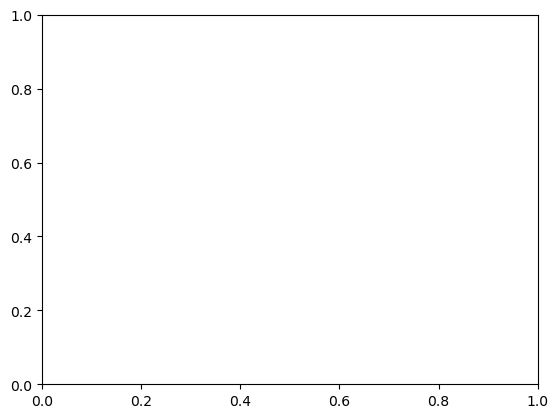

In [ ]:
accuracies = []
fig, ax = plt.subplots()
for i in range(1,11):
    accuracies.append(torch.load(f'stats-{i}.pt')['vals'])
# Plot the data
print(accuracies)
ax.plot(accuracies,marker='o', linestyle='-', color='b')

# Customize the plot
ax.set_title('Snow Classifier ResNet50 Accuracy')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Display the plot
plt.show()



0
{'epoch': 1, 'vals': [985, 265, 1075, 490, 1043, 132], 'loss': 0.889096750830648, 'training_loss': [0.997791071732839]}
1
{'epoch': 2, 'vals': [1124, 283, 1022, 274, 1141, 146], 'loss': 0.7891289808248219, 'training_loss': [0.997791071732839, 0.8321709613951426]}
2
{'epoch': 3, 'vals': [1131, 232, 1066, 266, 1163, 132], 'loss': 0.7485104741458606, 'training_loss': [0.997791071732839, 0.8321709613951426, 0.7703063923215109]}
3
{'epoch': 4, 'vals': [1156, 220, 1067, 213, 1206, 128], 'loss': 0.7247377087299088, 'training_loss': [0.997791071732839, 0.8321709613951426, 0.7703063923215109, 0.7400707044298687]}
4
{'epoch': 5, 'vals': [1164, 212, 1082, 204, 1214, 114], 'loss': 0.7070466013629932, 'training_loss': [0.997791071732839, 0.8321709613951426, 0.7703063923215109, 0.7400707044298687, 0.7215478590556553]}
5
{'epoch': 6, 'vals': [1162, 187, 1104, 200, 1221, 116], 'loss': 0.696805223949571, 'training_loss': [0.997791071732839, 0.8321709613951426, 0.7703063923215109, 0.7400707044298687, 0.7215478590556553, 0.7087079816394382]}
6
{'epoch': 7, 'vals': [1182, 178, 1093, 158, 1252, 127], 'loss': 0.6881113792720593, 'training_loss': [0.997791071732839, 0.8321709613951426, 0.7703063923215109, 0.7400707044298687, 0.7215478590556553, 0.7087079816394382, 0.6987809567224412]}
7
{'epoch': 8, 'vals': [1192, 191, 1106, 160, 1236, 105], 'loss': 0.6819212826720455, 'training_loss': [0.997791071732839, 0.8321709613951426, 0.7703063923215109, 0.7400707044298687, 0.7215478590556553, 0.7087079816394382, 0.6987809567224412, 0.6895344266815792]}
8
{'epoch': 9, 'vals': [1195, 190, 1120, 160, 1226, 99], 'loss': 0.6764888059973418, 'training_loss': [0.997791071732839, 0.8321709613951426, 0.7703063923215109, 0.7400707044298687, 0.7215478590556553, 0.7087079816394382, 0.6987809567224412, 0.6895344266815792, 0.6840578677162291]}
9
{'epoch': 10, 'vals': [1193, 158, 1124, 154, 1251, 110], 'loss': 0.6705284702598601, 'training_loss': [0.997791071732839, 0.8321709613951426, 0.7703063923215109, 0.7400707044298687, 0.7215478590556553, 0.7087079816394382, 0.6987809567224412, 0.6895344266815792, 0.6840578677162291, 0.6758457952075534]}

